This notebook contains different implementations of the **monte-carlo generator** for transactions, where **Poisson distribution** is responsible for finding transactions frequency and **defined in each section algorithms** are used for generating transactions values. Each chapter contains short description and definition for possible further document.

It is important to mention that for defining transaction time is used principle of "given time window" in which random generator picks timestamps. Such a pattern allows generating different scenarios, allowing to have either big transactions amount in short period of time, or small transactions amount in specific periods of time - just as random as it can be in real life.

All realizations are written as classes due to the need of having logical pattern in calling generator.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Normal distribution (initial version)

First version of the algorithm contains normal distribution algorithm for finding transaction values.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from scipy.stats import poisson
from random import randrange
import pandas as pd

In [ ]:
class PoissonGenerator:
    """
    Generate transactions timestamps list. Current version works with milliseconds.
    """
    def __init__(self, cycle_size: int, mean_occurencies: float):
        """
        Create a Poisson generator
        
        Keyword_arguments:
        cycle_size (int) -- reviewable cycle size in milliseconds
        mean_occurencies (float) -- mean amount of transactions
            happening in given cycle size
        """
        self.cycle_size = cycle_size
        self.mean_occurencies = mean_occurencies
        self.cumulative_probabilities = 0
        
        
    def __generate_poisson_outcome__(self) -> int:
        """
        Generate how many transactions will happen, considering cycle size 
        and mean transaction amount
        """
        return np.random.poisson(self.mean_occurencies, 1)[0]
    
    
    def generate_transactions(self, current_timestamp: datetime) -> list:
        """
        Generate array of transactions timestamps, considering Poisson distribution and
        random distribution of timestamps in given cycle size
        
        Keyword_arguments:
        current_timestamp (datetime) -- reviewable cycle starting point
        """
        transactions_timestamps = []
        current_transaction_count = self.__generate_poisson_outcome__()
        
        for i in range(current_transaction_count):
            transactions_timestamps.append(current_timestamp + timedelta(milliseconds=randrange(self.cycle_size)))
        
        return transactions_timestamps
    
    
    
class NormalGenerator:
    """
    Generate transaction values conform normal distribution
    """
    def __init__(self, mu: float=0, sigma: float=0):
        """
        Create a normal distribution generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price (default 0.0)
        sigma (float) -- standard deviation of transaction price (default 0.0)
        """
        self.mu = mu
        self.sigma = sigma
      
    
    def reset_params(self, mu: float, sigma: float):
        """
        Change parameters of existing generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price (default 0.0)
        sigma (float) -- standard deviation of transaction price (default 0.0)
        """
        self.mu = mu
        self.sigma = sigma
    

    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering mu and sigma
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        return np.random.normal(self.mu, self.sigma, transactions_count)

    
    
class Transaction:
    def __init__(self, id: int, timestamp: datetime, value: float):
        self.id = id
        self.timestamp = timestamp
        self.value = value
        
    
    def to_string(self) -> str:
        return str(
            'Transaction {id = ' + str(self.id) + 
            ', timestamp = "' + str(self.timestamp) + 
            '", value = ' + str(self.value) + '}'
        ) 
    
    
    
class MonteCarloTransactionSimulator:
    """
    Monte Carlo transactions generator, that generates transactions frequency using Poisson 
    distribution and transaction values using normal distribution (time metrics - milliseconds)
    """
    def __init__(
        self, transaction_density_generator: PoissonGenerator, transaction_values_generator: NormalGenerator, 
        first_currency: str, second_currency: str
    ):
        """
        Create a Monte-Carlo transaction simulator
        
        Keyword_arguments:
        transaction_density_generator (PoissonGenerator) -- Poisson transaction distribution generator
        transaction_values_generator (NormalGenerator) -- Normal transaction distribution generator
        """
        self.transaction_density_generator = transaction_density_generator
        self.transaction_values_generator = transaction_values_generator
        self.first_currency = first_currency
        self.second_currency = second_currency
        self.transaction_history = []
        
    
    def reset_values_generator_params(self, mu: float, sigma: float):
        """
        Change parameters of existing values (normal distribution) generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price (default 0.0)
        sigma (float) -- standard deviation of transaction price (default 0.0)
        """
        self.transaction_density_generator.reset_params(mu, sigma)
        
        
    def clear_transaction_history(self):
        """
        Clear all records from transaction history
        """
        self.transaction_history.clear()
    
    
    def generate_transactions(self, current_timestamp: datetime):
        """
        Generates transactions list with timestamps and values assigned to 
        
        Keyword arguments:
        current_timestamp (datetime) -- initial datetime point from where cycle will be reviewed
        """
        # generate timestamps (and sort them) and generate transaction values
        timestamps = self.transaction_density_generator.generate_transactions(current_timestamp)
        timestamps.sort()
        values = self.transaction_values_generator.generate_transactions(len(timestamps))
        
        # create transactions, appending them to the transaction history
        for index in range(len(timestamps)):
            new_transaction = Transaction(index, timestamps[index], values[index])
            self.transaction_history.append(new_transaction)
            
            
    def transaction_history_to_csv(self, filename: str):
        """
        Write transaction history to specified .csv file
        
        Keyword arguments:
        filename (str) -- name of .csv file where to write data
        """
        # form empty dataframe
        transaction_history_dataframe = pd.DataFrame(columns=['id', 'FirstCurrency', 'SecondCurrency', 'Timestamp', 'Value'])
        
        # append all new records to the dataframe
        for index in range(len(self.transaction_history)):
            new_row = {
                'id': self.transaction_history[index].id, 
                'FirstCurrency': self.first_currency, 
                'SecondCurrency': self.second_currency, 
                'Timestamp': self.transaction_history[index].timestamp,
                'Value': self.transaction_history[index].value
            }
            transaction_history_dataframe = transaction_history_dataframe.append(new_row, ignore_index=True)
        
        # if there is such file -> append new records to it, otherwise create a new file from existing table
        try:
            with open(filename) as f:
                transaction_history_dataframe.to_csv(filename, mode='a', header=False)
        except IOError:
            transaction_history_dataframe.to_csv(filename)

Example of calling this version

In [ ]:
# example of creating simulation
simulator = MonteCarloTransactionSimulator(PoissonGenerator(cycle_size=60000, mean_occurencies=5), 
                                            NormalGenerator(mu=10, sigma=5), 'ETH', 'DAI')

#  set starting point to be as current timestamp and then start loop, where after each iteration 
# reviewable timestamp will be updated by shifting it further conform generator cycle size
current_iteration_timestamp = datetime.now()
for index in range(60*24*7):
    simulator.generate_transactions(current_iteration_timestamp)
    current_iteration_timestamp += timedelta(milliseconds=randrange(simulator.transaction_density_generator.cycle_size))

# show all generated transactions
for index in range(len(simulator.transaction_history)):
    print(simulator.transaction_history[index].to_string())
    
# write all generated transactions (entire generated transaction history) to csv file
simulator.transaction_history_to_csv('history.csv')

# Truncated normal distribution with lower and upper bounds (second version, cooperation with Dmitri Trubca)

Instead of normal distribution here is used truncated normal distribution, introduced lower and upper bounds for distributions.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from scipy.stats import poisson, truncnorm
from random import randrange
import pandas as pd

In [ ]:
class PoissonGenerator:
    """
    Generate transactions timestamps list. Current version works with milliseconds.
    """
    def __init__(self, cycle_size: int, mean_occurencies: float):
        """
        Create a Poisson generator
        
        Keyword_arguments:
        cycle_size (int) -- reviewable cycle size in milliseconds
        mean_occurencies (float) -- mean amount of transactions
            happening in given cycle size
        """
        self.cycle_size = cycle_size
        self.mean_occurencies = mean_occurencies
        self.cumulative_probabilities = 0
        
        
    def __generate_poisson_outcome__(self) -> int:
        """
        Generate how many transactions will happen, considering cycle size 
        and mean transaction amount
        """
        return np.random.poisson(self.mean_occurencies, 1)[0]
    
    
    def generate_transactions(self, current_timestamp: datetime) -> list:
        """
        Generate array of transactions timestamps, considering Poisson distribution and
        random distribution of timestamps in given cycle size
        
        Keyword_arguments:
        current_timestamp (datetime) -- reviewable cycle starting point
        """
        transactions_timestamps = []
        current_transaction_count = self.__generate_poisson_outcome__()
        for i in range(current_transaction_count):
            transactions_timestamps.append(current_timestamp + timedelta(milliseconds=randrange(self.cycle_size)))
        return transactions_timestamps
    


class NormalGenerator:
    """
    Generate transaction values conform normal distribution
    """
    def __init__(self, mu: float, sigma: float, lower_bound: float, upper_bound: float):
        """
        Create a normal distribution generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price
        sigma (float) -- standard deviation of transaction price
        lower_bound (float) -- distribution lower bound
        upper_bound (float) -- distribution upper bound
        """
        if lower_bound > upper_bound:
            raise ValueError("creation: lower bound value can't be bigger than upper bound")
        elif mu < lower_bound:
            raise ValueError("creation: mean value (mu) can't be lower than lower bound")
        elif mu > upper_bound:
            raise ValueError("creation: mean value (mu) can't be bigger than upper bound")
        
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.mu = mu
        self.sigma = sigma
      
    
    def reset_mean_and_dev(self, mu: float, sigma: float):
        """
        Change mean and standard deviation parameters of existing generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price
        sigma (float) -- standard deviation of transaction price
        """
        if mu < self.lower_bound:
            raise ValueError("editing mu and sigma: mean value (mu) can't be lower than lower bound")
        elif mu > self.upper_bound:
            raise ValueError("editing mu and sigma: mean value (mu) can't be bigger than upper bound")
        
        self.mu = mu
        self.sigma = sigma
        
        
    def reset_lower_and_upper_bound(self, lower_bound: float, upper_bound: float):
        """
        Change distribution lower and upper bounds
        
        Keyword arguments:
        lower_bound (float) -- distribution lower bound
        upper_bound (float) -- distribution upper bound
        """
        if lower_bound > upper_bound:
            raise ValueError("bounds editing: lower bound value can't be bigger than upper bound")
        elif self.mu < lower_bound:
            raise ValueError("bounds editing: mean value (mu) can't be lower than lower bound")
        elif self.mu > upper_bound:
            raise ValueError("bounds editing: mean value (mu) can't be bigger than upper bound")
        
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
    
    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering mu and sigma
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        return truncnorm.rvs(
            (self.lower_bound - self.mu)/self.sigma, 
            (self.upper_bound - self.mu)/self.sigma, 
            loc=self.mu, scale=self.sigma, size=transactions_count
        )



class Transaction:
    """
    Class with information regarding swapping transaction
    """
    def __init__(self, timestamp: datetime, 
                token_in_amount: float, token_in: str, 
                token_out: str, 
                slope: float=0.05):
        self.datetime_timestamp = timestamp
        self.token_in = token_in
        self.token_in_amount = token_in_amount
        self.token_out = token_out
        self.token_out_amount = None
        self.slope = slope


    def set_token_out_amount(self, token_out_amount: float):
        self.token_out_amount = token_out_amount
        
    
    def to_string(self) -> str:
        return str(
            'Transaction {datetime timestamp = ' + str(self.datetime_timestamp) + 
            ', token in amount = "' + str(self.token_in_amount) + 
            '", token in name = ' + str(self.token_in) + 
            ', token out amount = ' + str(self.token_out_amount) + 
            ', token out name = ' + str(self.token_out) + 
            ', slope = ' + str(self.slope) + '}'
        )
    
    
    
class MonteCarloTransactionSimulator:
    """
    Monte Carlo transactions generator, that generates transactions frequency using Poisson 
    distribution and transaction values using normal distribution (time metrics - milliseconds)
    """
    def __init__(
        self, frequency_generator: PoissonGenerator, token_in_generator: NormalGenerator, 
        first_currency: str, second_currency: str
    ):
        """
        Create a Monte-Carlo transaction simulator
        
        Keyword_arguments:
        frequency_generator (PoissonGenerator) -- Poisson transaction distribution generator
        token_in_generator (NormalGenerator) -- Normal transaction distribution generator
        first_currency -- name of the first token in transaction
        second_currency -- name of the second token in transaction
        """
        self.frequency_generator = frequency_generator
        self.token_in_generator = token_in_generator
        self.first_currency = first_currency
        self.second_currency = second_currency
        self.transaction_history = []
        
    
    def reset_values_generator_params(self, mu: float, sigma: float):
        """
        Change parameters of existing values (normal distribution) generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price (default 0.0)
        sigma (float) -- standard deviation of transaction price (default 0.0)
        """
        self.frequency_generator.reset_params(mu, sigma)
        
        
    def reset_values_generator_bounds(self, lower_bound: float, upper_bound: float):
        self.token_in_genererator.reset_lower_and_upper_bound(
            lower_bound=lower_bound, upper_bound=upper_bound
        )
        
        
    def clear_transaction_history(self):
        """
        Clear all records from transaction history
        """
        self.transaction_history.clear()
    
    
    def generate_transactions(self, current_timestamp: datetime):
        """
        Generates transactions list with timestamps and token_in values. All transactions are recorded
        to the 'transaction_history' variable.
        
        Keyword arguments:
        current_timestamp (datetime) -- initial datetime point from where cycle will be reviewed
        current_amm_coef (float) -- current AMM market coefficient that defines price of out
            token relative to in token
        """
        # generate timestamps and token_in values
        timestamps = self.frequency_generator.generate_transactions(current_timestamp)
        timestamps.sort()
        token_in_values = self.token_in_generator.generate_transactions(len(timestamps))
        
        # form new transactions and record them into 'transaction history' variable
        for index in range(len(timestamps)):
            new_transaction = Transaction(
                timestamp=timestamps[index], 
                token_in_amount=token_in_values[index], 
                token_in=self.first_currency,
                token_out=self.second_currency
            )
            self.transaction_history.append(new_transaction)


    def get_history(self) -> list:
        """
        Get transaction history
        """
        return self.transaction_history
            
            
    def transaction_history_to_csv(self, filename: str):
        """
        Write transaction history to specified .csv file
        
        Keyword arguments:
        filename (str) -- name of .csv file where to write data
        """
        # form empty dataframe
        transaction_history_dataframe = pd.DataFrame(columns=['datetime_timestamp', 'TokenIn', 'TokenInAmount', 
                                                              'TokenOut', 'TokenOutAmount', 'Slope'])
        
        # append all new records to the dataframe
        for index in range(len(self.transaction_history)):
            new_row = {'datetime_timestamp': self.transaction_history[index].datetime_timestamp,
                    'TokenIn': self.transaction_history[index].token_in,
                    'TokenInAmount': self.transaction_history[index].token_in_amount, 
                    'TokenOut': self.transaction_history[index].token_out,
                    'TokenOutAmount': self.transaction_history[index].token_out_amount,
                    'Slope': self.transaction_history[index].slope}
            
            transaction_history_dataframe = transaction_history_dataframe.append(new_row, ignore_index=True)
        
        # either append new records to the existing file, or create a new one from existing table
        try:
            with open(filename) as f:
                transaction_history_dataframe.to_csv(filename, mode='a', header=False)
        except IOError:
            transaction_history_dataframe.to_csv(filename)

In [ ]:
# create simulator with specifying parameters of the normal distribution for token_in
# value estimation and Poisson distribution for transaction frequency estimation
simulator = MonteCarloTransactionSimulator(PoissonGenerator(cycle_size=60000, mean_occurencies=500), 
                                            NormalGenerator(mu=10, sigma=5, lower_bound=5, upper_bound=15), 'ETH', 'DAI')

# set current timestamp as starting point and start loop, where each iteration shifts reviewable
# timestamp further conform simulator cycle size
current_iteration_timestamp = datetime.now()
for index in range(60*24*7):
    simulator.generate_transactions(current_iteration_timestamp)
    current_iteration_timestamp += timedelta(milliseconds=randrange(simulator.frequency_generator.cycle_size))

# show generated transactions history
for index in range(int(len(simulator.transaction_history) / 10)):
    print(simulator.transaction_history[index].to_string())

# Cauchy and Pareto generators (third version)

After performing data analysis of pool transactions distributions and shares transactions distributions it was decided also to create Pareto and Cauchy generators. Due to the complex structure, classes will be separated on modules

In [13]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from scipy.stats import poisson, truncnorm
from random import randrange
import pandas as pd
from scipy.stats import halfcauchy 


## Poisson part for defining transaction amount on given time period

In [2]:
class PoissonGenerator:
    """
    Generate transactions timestamps list. Current version works with milliseconds.
    """
    def __init__(self, cycle_size: int, mean_occurencies: float):
        """
        Create a Poisson generator
        
        Keyword_arguments:
        cycle_size (int) -- reviewable cycle size in milliseconds
        mean_occurencies (float) -- mean amount of transactions
            happening in given cycle size
        """
        self.cycle_size = cycle_size
        self.mean_occurencies = mean_occurencies
        self.cumulative_probabilities = 0
        
        
    def __generate_poisson_outcome__(self) -> int:
        """
        Generate how many transactions will happen, considering cycle size 
        and mean transaction amount
        """
        return np.random.poisson(self.mean_occurencies, 1)[0]
    
    
    def generate_transactions(self, current_timestamp: datetime) -> list:
        """
        Generate array of transactions timestamps, considering Poisson distribution and
        random distribution of timestamps in given cycle size
        
        Keyword_arguments:
        current_timestamp (datetime) -- reviewable cycle starting point
        """
        transactions_timestamps = []
        current_transaction_count = self.__generate_poisson_outcome__()
        for i in range(current_transaction_count):
            transactions_timestamps.append(current_timestamp + timedelta(milliseconds=randrange(self.cycle_size)))
        return transactions_timestamps

## Transaction generators

Here are present all 3 versions how to generate transaction history (Cauchy, Pareto and normal distributions)

### Normal distribution

In [3]:
class NormalGenerator:
    """
    Generate transaction values conform normal distribution
    """
    def __init__(self, mu: float, sigma: float, lower_bound: float, upper_bound: float):
        """
        Create a normal distribution generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price
        sigma (float) -- standard deviation of transaction price
        lower_bound (float) -- distribution lower bound
        upper_bound (float) -- distribution upper bound
        """
        if lower_bound > upper_bound:
            raise ValueError("creation: lower bound value can't be bigger than upper bound")
        elif mu < lower_bound:
            raise ValueError("creation: mean value (mu) can't be lower than lower bound")
        elif mu > upper_bound:
            raise ValueError("creation: mean value (mu) can't be bigger than upper bound")
        
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.mu = mu
        self.sigma = sigma
      
    
    def reset_params(self, mu: float, sigma: float, lower_bound: float, upper_bound: float):
        """
        Change mean and standard deviation parameters of existing generator
        
        Keyword_arguments:
        mu (float) -- mean transaction price
        sigma (float) -- standard deviation of transaction price
        lower_bound (float) -- distribution lower bound
        upper_bound (float) -- distribution upper bound
        """
        if lower_bound > upper_bound:
            raise ValueError("bounds editing: lower bound value can't be bigger than upper bound")
        elif mu < lower_bound:
            raise ValueError("bounds editing: mean value (mu) can't be lower than lower bound")
        elif mu > upper_bound:
            raise ValueError("bounds editing: mean value (mu) can't be bigger than upper bound")
        
        self.mu = mu
        self.sigma = sigma
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
    
    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering mu and sigma
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        return truncnorm.rvs((self.lower_bound - self.mu)/self.sigma, 
                            (self.upper_bound - self.mu)/self.sigma, 
                            loc=self.mu, scale=self.sigma, size=transactions_count)

## Cauchy distribution

In [5]:
class CauchyGenerator:
    """
    Generate transaction values conform Cauchy distribution
    """
    def __init__(self, loc: float, scale: float):
        """
        Create Cauchy generator with initial parameters
        
        Keyword_arguments:
        loc (float) -- locational parameter that defines where distribution
            will be centered
        scale (float) -- how far will tales (distribution) go
        """
        self.loc = loc
        self.scale = scale
      
    
    def reset_params(self, loc: float, scale: float):
        """
        Change mean and standard deviation parameters of existing generator
        
        Keyword_arguments:
        loc (float) -- locational parameter that defines where distribution
            will be centered
        scale (float) -- how far will tales (distribution) go
        """
        self.loc = loc
        self.scale = scale
        
    
    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering mu and sigma
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        return halfcauchy.rvs(size=transactions_count, loc=self.loc, scale=self.scale)


### Log-normal distribution

In [6]:
class LognormalGenerator:
    """
    Generate transaction values conform Cauchy distribution
    """
    def __init__(self, mean: float, sigma: float):
        """
        Create Log-normal generator with initial parameters
        
        Keyword_arguments:
        mean (float) -- mean distribution value
        sigma (float) -- standard deviation
        """
        self.mean = mean
        self.sigma = sigma
      
    
    def reset_params(self, mean: float, sigma: float):
        """
        Change log-normal generator parameters
        
        Keyword_arguments:
        mean (float) -- mean distribution value
        sigma (float) -- standard deviation
        """
        self.mean = mean
        self.sigma = sigma
        
    
    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering mu and sigma
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        return np.random.lognormal(mean=self.mean, sigma=self.sigma, size=transactions_count)


### Pareto distribution

In [7]:
class ParetoGenerator:
    """
    Generate transaction values conform Pareto distribution
    """
    def __init__(self, shape: float):
        """
        Create Cauchy generator with initial parameters
        
        Keyword_arguments:
        shape (float) -- shape of distribution
        """
        self.shape = shape
      
    
    def reset_params(self, shape: float):
        """
        Change distribution shape

        Keyword arguments:
        shape (float) -- distribution shape
        """
        self.shape = shape
        
    
    def generate_transactions(self, transactions_count: int) -> list:
        """
        Generate transaction prices list considering params
        
        Keyword_arguments:
        transactions_count (int) -- required transactions count
        """
        return np.random.pareto(self.shape, size=transactions_count)


## Transaction class

In [8]:
class Transaction:
    """
    Class with information regarding swapping transaction
    """
    def __init__(self, timestamp: datetime, 
                token_in_amount: float, token_in: str, 
                token_out: str, 
                slope: float=0.05):
        self.datetime_timestamp = timestamp
        self.token_in = token_in
        self.token_in_amount = token_in_amount
        self.token_out = token_out
        self.token_out_amount = None
        self.slope = slope


    def set_token_out_amount(self, token_out_amount: float):
        self.token_out_amount = token_out_amount
        
    
    def to_string(self) -> str:
        return str(
            'Transaction {datetime timestamp = ' + str(self.datetime_timestamp) + 
            ', token in amount = "' + str(self.token_in_amount) + 
            '", token in name = ' + str(self.token_in) + 
            ', token out amount = ' + str(self.token_out_amount) + 
            ', token out name = ' + str(self.token_out) + 
            ', slope = ' + str(self.slope) + '}'
        )

    
    def to_record(self) -> np.array:
        """
        Transform transaction data into numpy array of data
        """
        return np.array([
            self.datetime_timestamp,
            self.token_in,
            self.token_in_amount,
            self.token_out,
            self.token_out_amount,
            self.slope
        ])

## Monte-Carlo generator

Generator works by such principle that allows 

In [53]:
class MonteCarloTransactionSimulator:
    """
    Monte Carlo transactions generator, that generates transactions frequency using Poisson 
    distribution and transaction values using normal distribution (time metrics - milliseconds)
    """
    def __init__(
        self, frequency_generator: PoissonGenerator, token_in_generator, 
        first_currency: str, second_currency: str
    ):
        """
        Create a Monte-Carlo transaction simulator
        
        Keyword_arguments:
        frequency_generator (PoissonGenerator) -- Poisson transaction distribution generator
        token_in_generator -- transaction distribution generator (accepts normal, Cauchy and 
            Pareto)
        first_currency -- name of the first token in transaction
        second_currency -- name of the second token in transaction
        """
        self.frequency_generator = frequency_generator
        self.token_in_generator = token_in_generator
        self.first_currency = first_currency
        self.second_currency = second_currency
        self.transaction_history = []
        
    
    def get_token_in_generator(self):
        """
        Get transactions distribution generator (can be normal, Cauchy and Pareto)
        """
        return self.token_in_generator
        
        
    def clear_transaction_history(self):
        """
        Clear all records from transaction history
        """
        self.transaction_history.clear()
    
    
    def generate_transactions(self, current_timestamp: datetime):
        """
        Generates transactions list with timestamps and token_in values. All transactions are recorded
        to the 'transaction_history' variable.
        
        Keyword arguments:
        current_timestamp (datetime) -- initial datetime point from where cycle will be reviewed
        current_amm_coef (float) -- current AMM market coefficient that defines price of out
            token relative to in token
        """
        # generate timestamps and token_in values
        timestamps = self.frequency_generator.generate_transactions(current_timestamp)
        token_in_values = self.token_in_generator.generate_transactions(len(timestamps))
        
        # form new transactions and record them into 'transaction history' variable
        for index in range(len(timestamps)):
            self.transaction_history.append(Transaction(timestamp=timestamps[index], 
                                                        token_in_amount=token_in_values[index], 
                                                        token_in=self.first_currency,
                                                        token_out=self.second_currency))


    def get_history(self) -> list:
        """
        Get transaction history
        """
        return self.transaction_history
            
            
    def transaction_history_to_csv(self, filename: str):
        """
        Write transaction history to specified .csv file
        
        Keyword arguments:
        filename (str) -- name of .csv file where to write data
        """
        # vectorize all transactions into numpy matrix and then make dataframe out of it
        transactions_matrix = np.array([transaction.to_record() for transaction in self.transaction_history])
        transaction_history_df = pd.DataFrame(data=transactions_matrix, columns=['datetime_timestamp', 'TokenIn', 'TokenInAmount', 
                                                                                 'TokenOut', 'TokenOutAmount', 'Slope'])

        # fix transformation of numerical features into string at numpy stage to numerical again
        transaction_history_df['TokenInAmount'] = pd.to_numeric(transaction_history_df['TokenInAmount'])
        transaction_history_df['TokenOutAmount'] = pd.to_numeric(transaction_history_df['TokenOutAmount'])
        
        # either append new records to the existing file, or create a new one from existing table
        try:
            with open(filename) as f:
                transaction_history_df.to_csv(filename, mode='a', header=False)
        except IOError:
            transaction_history_df.to_csv(filename)


    def get_dataframe(self) -> pd.DataFrame:
        # vectorize all transactions into numpy matrix and then make dataframe out of it
        transactions_matrix = np.array([transaction.to_record() for transaction in self.transaction_history])
        transaction_history_df = pd.DataFrame(data=transactions_matrix, columns=['datetime_timestamp', 'TokenIn', 'TokenInAmount', 
                                                                                 'TokenOut', 'TokenOutAmount', 'Slope'])

        # fix transformation of numerical features into string at numpy stage to numerical again
        transaction_history_df['TokenInAmount'] = pd.to_numeric(transaction_history_df['TokenInAmount'])
        transaction_history_df['TokenOutAmount'] = pd.to_numeric(transaction_history_df['TokenOutAmount'])

        return transaction_history_df

## Examples of calling Monte-Carlo generators versions

In [62]:
# several simulators, where each uses its unique values generator
normal_simulator = MonteCarloTransactionSimulator(PoissonGenerator(cycle_size=60000, mean_occurencies=2), 
                                                    NormalGenerator(mu=0, sigma=4500, lower_bound=0, upper_bound=10000), 'ETH', 'DAI')

cauchy_simulator = MonteCarloTransactionSimulator(PoissonGenerator(cycle_size=60000, mean_occurencies=2), 
                                                    CauchyGenerator(loc=0, scale=1000), 'ETH', 'DAI')

pareto_simulator = MonteCarloTransactionSimulator(PoissonGenerator(cycle_size=60000, mean_occurencies=2), 
                                                    ParetoGenerator(shape=3), 'ETH', 'DAI')

lognormal_simulator = MonteCarloTransactionSimulator(PoissonGenerator(cycle_size=60000, mean_occurencies=2), 
                                                        LognormalGenerator(mean=0, sigma=1), 'ETH', 'DAI')

# set current timestamp as starting point and start loop, where each iteration shifts reviewable
# timestamp further conform simulator cycle size
current_iteration_timestamp = datetime.now()
for index in range(60*24*7):
    normal_simulator.generate_transactions(current_iteration_timestamp)
    cauchy_simulator.generate_transactions(current_iteration_timestamp)
    pareto_simulator.generate_transactions(current_iteration_timestamp)
    lognormal_simulator.generate_transactions(current_iteration_timestamp)
    current_iteration_timestamp += timedelta(milliseconds=normal_simulator.frequency_generator.cycle_size)

In [63]:
normal_df = normal_simulator.get_dataframe()    
cauchy_df = cauchy_simulator.get_dataframe()
pareto_df = pareto_simulator.get_dataframe()
lognormal_df = lognormal_simulator.get_dataframe()

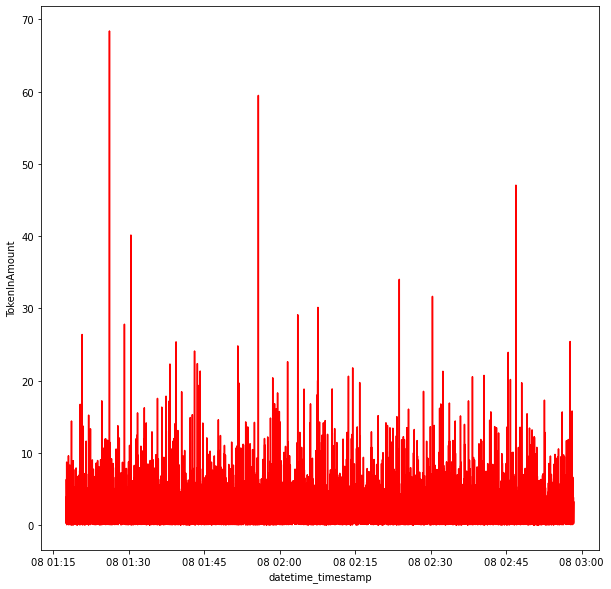

In [56]:
plt.figure(figsize=(10, 10))
sns.lineplot(data=lognormal_df, x="datetime_timestamp", y="TokenInAmount", color='red')
plt.show()

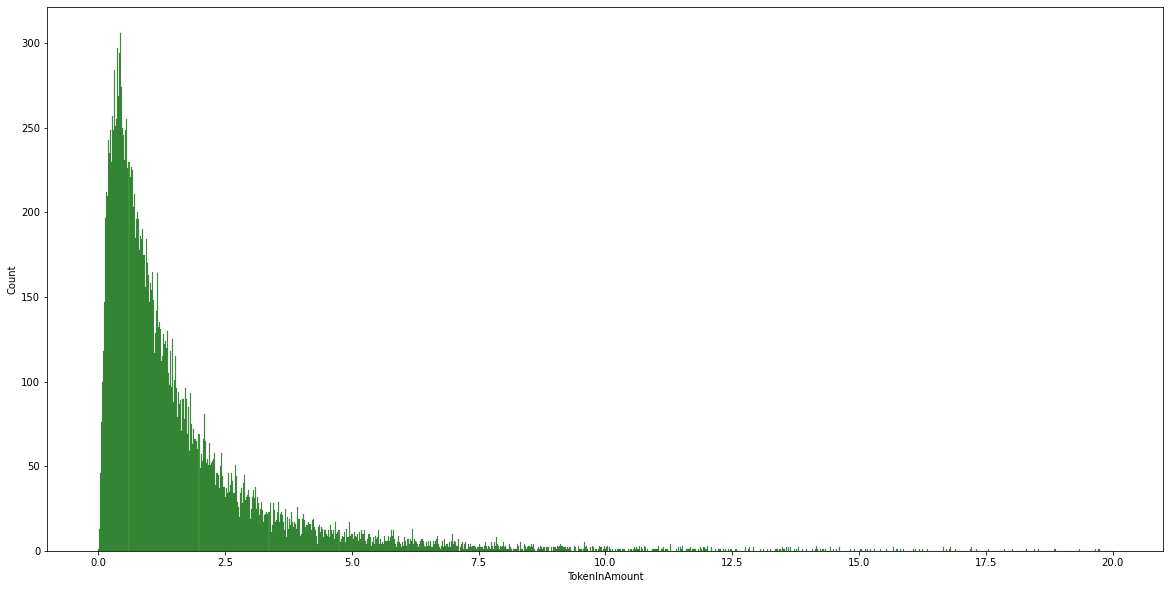

In [57]:
plt.figure(figsize=(20, 10))
sns.histplot(data=lognormal_df, x="TokenInAmount", color='green', bins=1000, binrange=[0, 20])
plt.show()

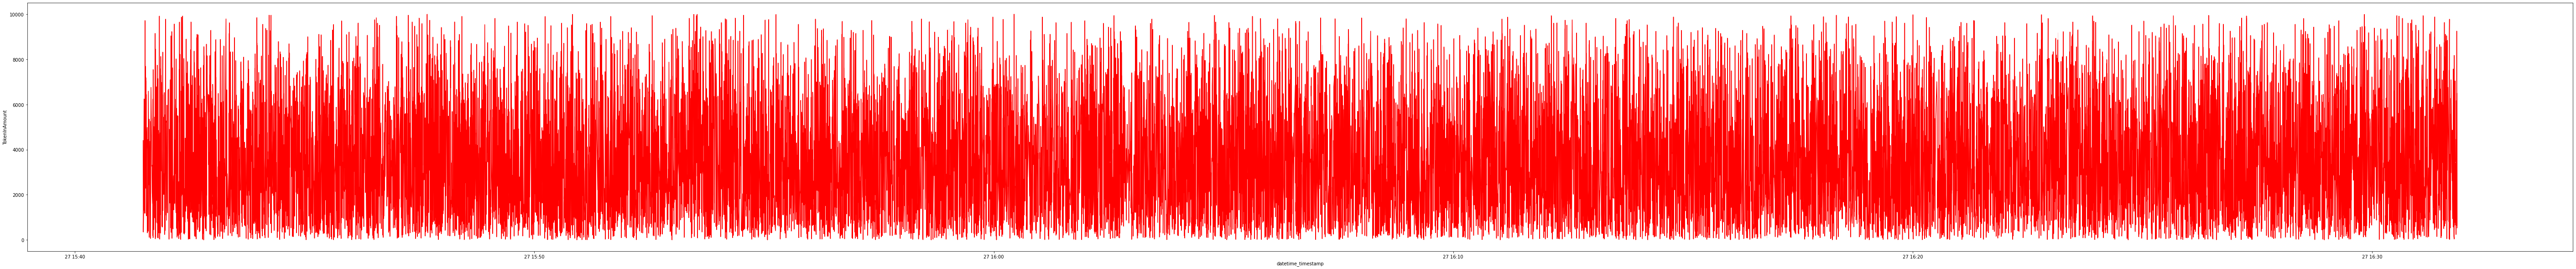

In [96]:
plt.figure(figsize=(100, 10))
sns.lineplot(data=normal_df, x="datetime_timestamp", y="TokenInAmount", color='red')
plt.show()

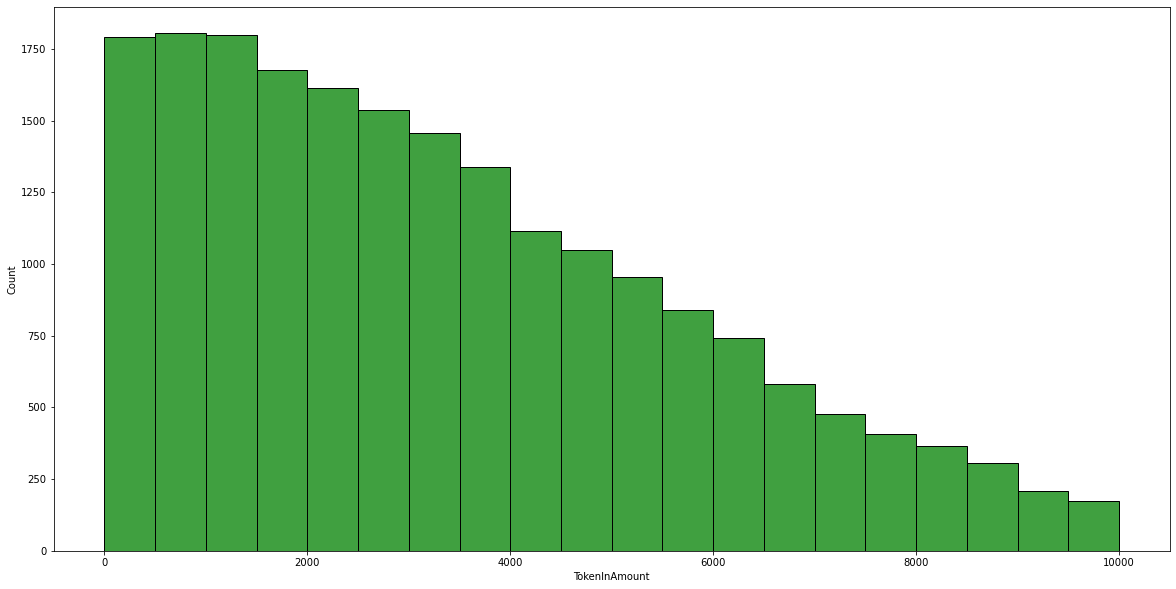

In [97]:
plt.figure(figsize=(20, 10))
sns.histplot(data=normal_df, x="TokenInAmount", color='green', bins=20)
plt.show()

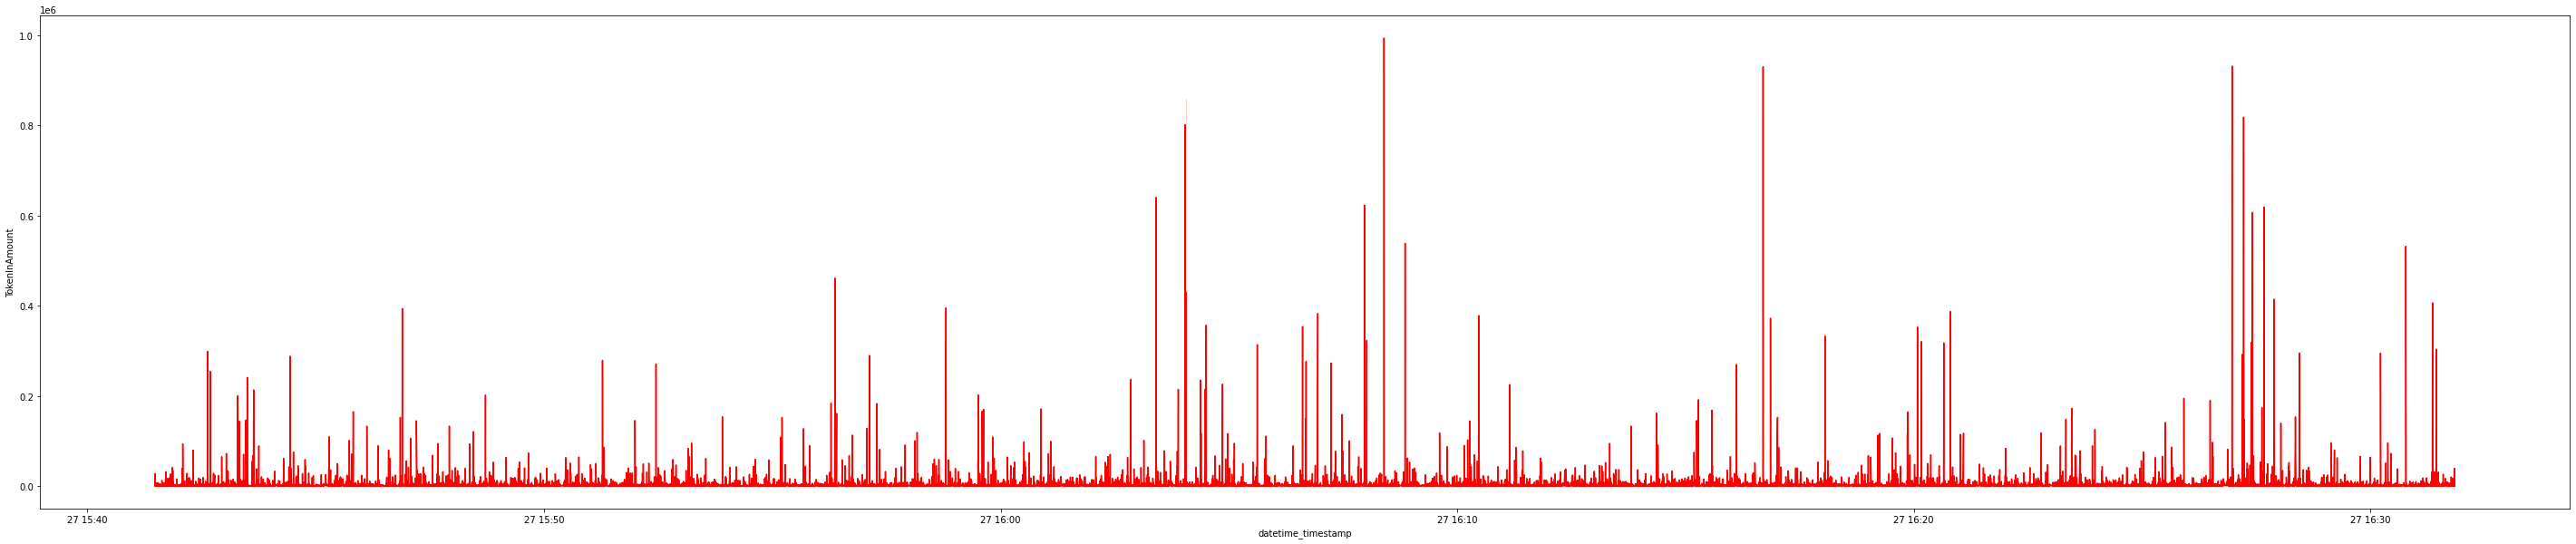

In [114]:
plt.figure(figsize=(50, 10))
sns.lineplot(data=cauchy_df[cauchy_df["TokenInAmount"] < 1000000], x="datetime_timestamp", y="TokenInAmount", color='red')
plt.show()

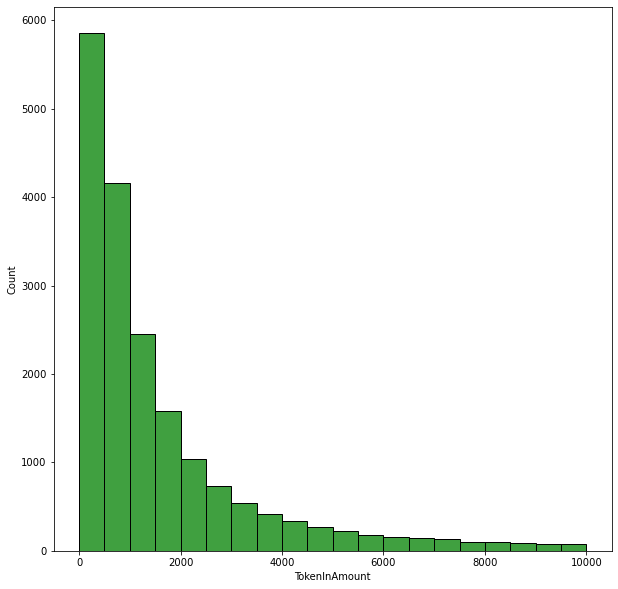

In [99]:
plt.figure(figsize=(10, 10))
sns.histplot(data=cauchy_df, x="TokenInAmount", color='green', bins=20, binrange=[0, 10000])
plt.show()

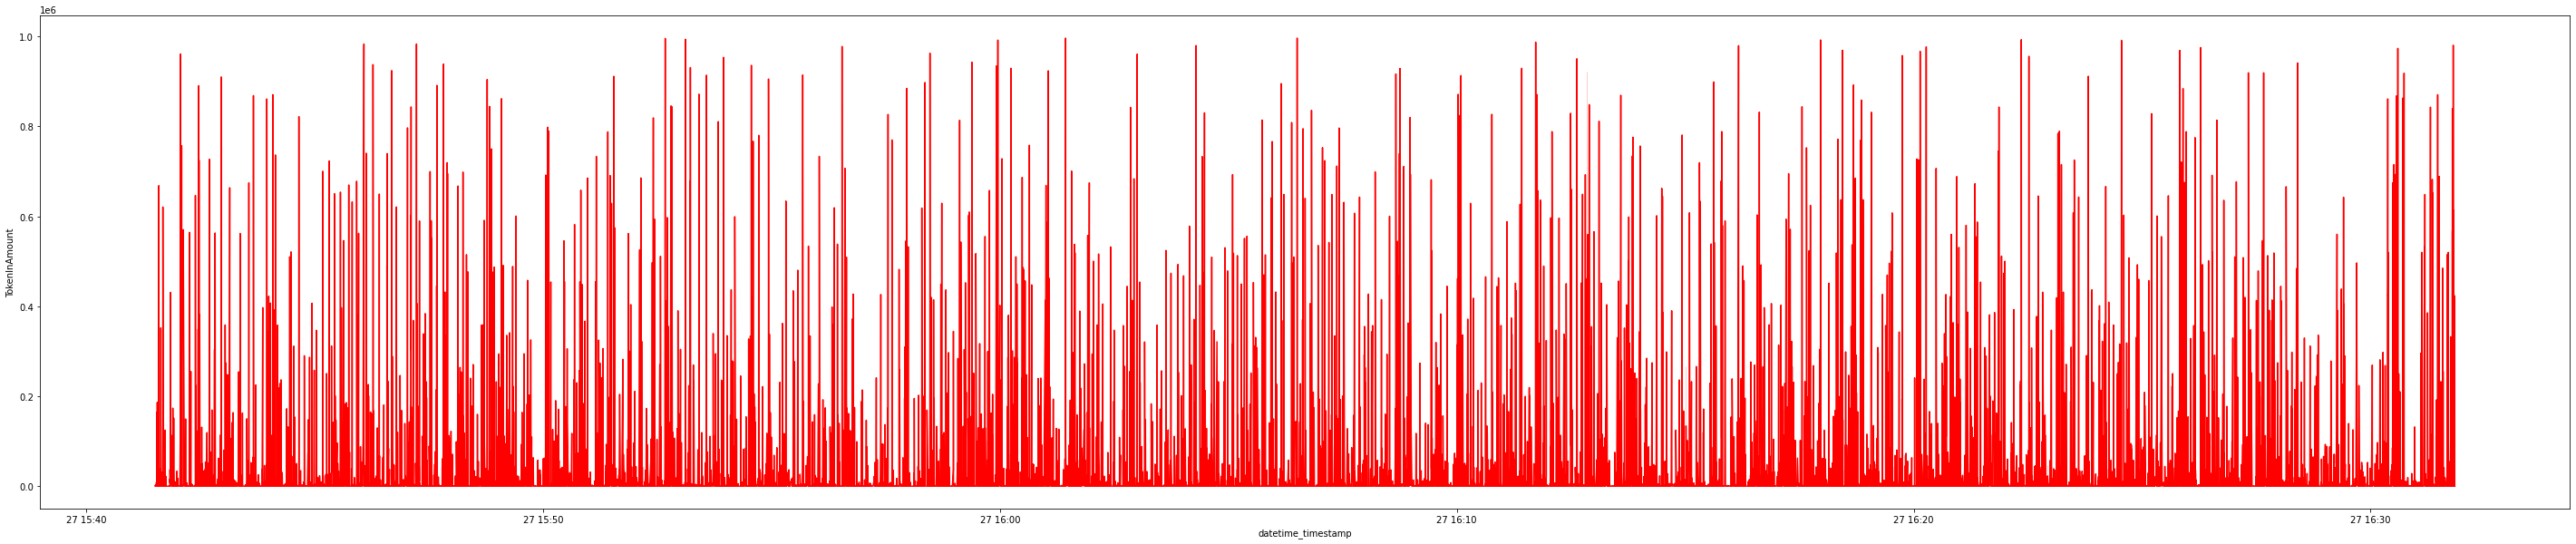

In [112]:
plt.figure(figsize=(50, 10))
sns.lineplot(data=pareto_df[pareto_df['TokenInAmount'] < 1000000], x="datetime_timestamp", y="TokenInAmount", color='red')
plt.show()

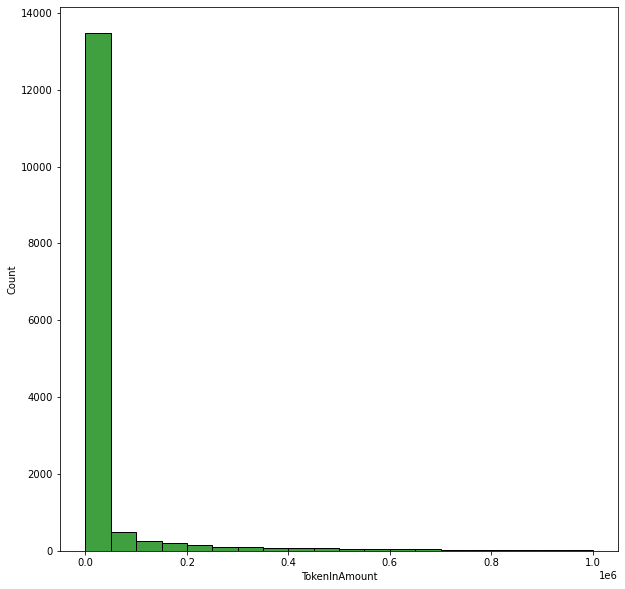

In [110]:
plt.figure(figsize=(10, 10))
sns.histplot(data=pareto_df, x="TokenInAmount", color='green', bins=20, binrange=[0, 1000000])
plt.show()